In [1]:
from dask.distributed import Client, progress

In [2]:
client = Client(threads_per_worker=1, n_workers=10)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 10,Total memory: 78.60 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45703,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 78.60 GiB
Comm: tcp://127.0.0.1:35545,Total threads: 1
Dashboard: http://127.0.0.1:40931/status,Memory: 7.86 GiB
Nanny: tcp://127.0.0.1:42327,


In [3]:
import time
import random

def costly_simulation(list_param):
    time.sleep(random.random())
    return sum(list_param)

In [4]:
%time costly_simulation([1, 2, 3, 4])

CPU times: user 105 ms, sys: 44.6 ms, total: 150 ms
Wall time: 837 ms


10

In [5]:
import pandas as pd
import numpy as np

input_params = pd.DataFrame(np.random.random(size=(500, 4)),
                            columns=['param_a', 'param_b', 'param_c', 'param_d'])
input_params.head()


,param_a,param_b,param_c,param_d
0,0.158383,0.153487,0.008851,0.851704
1,0.457555,0.993624,0.599530,0.089513
2,0.050336,0.448694,0.186016,0.258208
3,0.466902,0.124382,0.717180,0.267196
4,0.472770,0.597918,0.966242,0.349274


In [6]:
results = []

In [7]:
%%time
for parameters in input_params.values[:10]:
    result = costly_simulation(parameters)
    results.append(result)

CPU times: user 417 ms, sys: 203 ms, total: 620 ms
Wall time: 3.68 s


In [8]:
results

[1.1724256901265813,
 2.140222146520272,
 0.9432533487870429,
 1.5756588824707731,
 2.386204055729744,
 1.1798028835592493,
 1.958086075823078,
 3.1522962030748785,
 1.011643317938582,
 1.996656092311242]

# ==== Dask Delayed ====

In [9]:
import dask
lazy_results = []

In [10]:
%%time

for parameters in input_params.values[:10]:
    lazy_result = dask.delayed(costly_simulation)(parameters)
    lazy_results.append(lazy_result)

CPU times: user 3.67 ms, sys: 0 ns, total: 3.67 ms
Wall time: 2.99 ms


In [11]:
lazy_results[0]

Delayed('costly_simulation-e1e475e6-c4b3-479c-a327-7ebcb8bd8639')

In [12]:
%time dask.compute(*lazy_results)

CPU times: user 307 ms, sys: 72.1 ms, total: 379 ms
Wall time: 1.15 s


(1.1724256901265813,
 2.140222146520272,
 0.9432533487870429,
 1.5756588824707731,
 2.386204055729744,
 1.1798028835592493,
 1.958086075823078,
 3.1522962030748785,
 1.011643317938582,
 1.996656092311242)

In [13]:
import dask
lazy_results = []

for parameters in input_params.values:
    lazy_result = dask.delayed(costly_simulation)(parameters)
    lazy_results.append(lazy_result)

futures = dask.persist(*lazy_results)  # trigger computation in the background


In [14]:
client.cluster.scale(10)  # ask for ten 4-thread workers

In [15]:
results = dask.compute(*futures)
results[:5]

(1.1724256901265813,
 2.140222146520272,
 0.9432533487870429,
 1.5756588824707731,
 2.386204055729744)

# ==== KubeCluster ====

In [ ]:
from dask_kubernetes import KubeCluster, make_pod_spec

pod_spec = make_pod_spec(image='daskdev/dask:latest',
                         memory_limit='1G', memory_request='1G',
                         cpu_limit=1, cpu_request=1,
                         env={'EXTRA_PIP_PACKAGES': 'fastparquet git+https://github.com/dask/distributed'})
cluster = KubeCluster(pod_spec)
cluster.scale(6)

Creating scheduler pod on cluster. This may take some time.


In [ ]:
#cluster.adapt(minimum=1, maximum=100)

In [ ]:
# cluster = KubeCluster('worker-template.yml')
# cluster = KubeCluster({...})

In [ ]:
# cluster.adapt()

In [ ]:
from dask.distributed import Client
client = Client(cluster)

In [ ]:
# client.get_versions(check=True)

In [ ]:
client

In [ ]:
import dask.array as da

In [10]:
# Create a large array and calculate the mean
array = da.ones((1000, 1000, 1000))
print(array.mean().compute())  # Should print 1.0

1.0


In [16]:
import joblib
from joblib import Parallel, delayed, cpu_count

In [17]:
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [18]:
with pm.Model() as model:
    x = pm.Normal('x', mu = 1, sd =2)

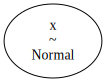

In [19]:
pm.model_to_graphviz(model)

In [21]:
with model:
    trace = pm.sample()

/tmp/ipykernel_523140/366605620.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample()


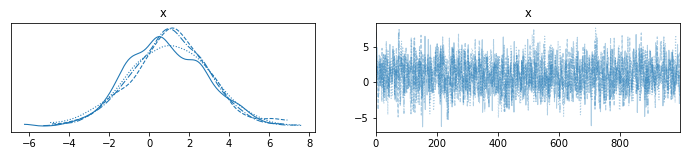

In [24]:
with model:
    pm.plot_trace(trace)

In [18]:
def run_model(i=None):
    with pm.Model() as model:
        x = pm.Normal('x', mu = 1, sd =2)
        trace = pm.sample(chains = 1, cores = 1)
    return trace

/tmp/ipykernel_648423/2507702576.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(chains = 1, cores = 1)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [x]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
The acceptance probability does not match the target. It is 0.8842034722184178, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
Got error No model on context stack. trying to find log_likelihood in translation.
/home/abuzarmahmood/anaconda3/envs/pymc3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

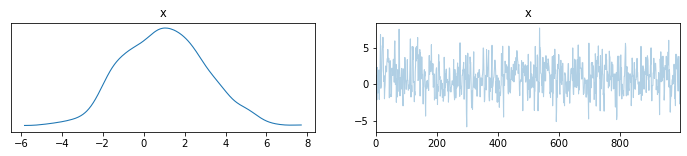

In [19]:
pm.plot_trace(run_model())

In [20]:
with joblib.parallel_backend('dask'):
    Parallel(n_jobs = 10, verbose=100)(delayed(run_model)() for i in range(15))

[Parallel(n_jobs=10)]: Using backend DaskDistributedBackend with 10 concurrent workers.


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/tmp/ipykernel_648423/2507702576.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` 

Sequential sampling (1 chains in 1 job)
NUTS: [x]


Sequential sampling (1 chains in 1 job)
NUTS: [x]


Sequential sampling (1 chains in 1 job)
NUTS: [x]
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 4 seconds.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Sequential sampling (1 chains in 1 job)
NUTS: [x]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 5 seconds.
/tmp/ipykernel_648423/2507702576.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jit

[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:   21.2s


Sequential sampling (1 chains in 1 job)
NUTS: [x]
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
NUTS: [x]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.


[Parallel(n_jobs=10)]: Done   2 out of  15 | elapsed:   22.3s remaining:  2.4min


Only one chain was sampled, this makes it impossible to run some convergence checks
/tmp/ipykernel_648423/2507702576.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[Parallel(n_jobs=10)]: Done   3 out of  15 | elapsed:   22.5s remaining:  1.5min


Sequential sampling (1 chains in 1 job)
NUTS: [x]
/tmp/ipykernel_648423/2507702576.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Sequential sampling (1 chains in 1 job)
NUTS: [x]
The acceptance probability does not match the target. It is 0.8869852620195773, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
NUTS: [x]
/tmp/ipykernel_648423/2507702576.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[Parallel(n_jobs=10)]: Done   4 out of  15 | elapsed:   23.1s remaining:  1.1min


Sequential sampling (1 chains in 1 job)
NUTS: [x]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


The acceptance probability does not match the target. It is 0.879164466251701, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
/tmp/ipykernel_648423/2507702576.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[Parallel(n_jobs=10)]: Done   5 out of  15 | elapsed:   23.5s remaining:   47.1s
[Parallel(n_jobs=10)]: Done   6 out of  15 | elapsed:   23.6s remaining:   35.4s


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
NUTS: [x]
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.719548555400276, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


[Parallel(n_jobs=10)]: Done   7 out of  15 | elapsed:   23.9s remaining:   27.3s
[Parallel(n_jobs=10)]: Done   8 out of  15 | elapsed:   24.1s remaining:   21.0s


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
NUTS: [x]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2 seconds.


[Parallel(n_jobs=10)]: Done   9 out of  15 | elapsed:   24.8s remaining:   16.5s
[Parallel(n_jobs=10)]: Done  10 out of  15 | elapsed:   24.8s remaining:   12.4s


Sequential sampling (1 chains in 1 job)
NUTS: [x]


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Sequential sampling (1 chains in 1 job)
NUTS: [x]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2 seconds.


[Parallel(n_jobs=10)]: Done  11 out of  15 | elapsed:   26.6s remaining:    9.7s


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Only one chain was sampled, this makes it impossible to run some convergence checks


[Parallel(n_jobs=10)]: Done  12 out of  15 | elapsed:   27.1s remaining:    6.8s


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Only one chain was sampled, this makes it impossible to run some convergence checks


[Parallel(n_jobs=10)]: Done  13 out of  15 | elapsed:   28.8s remaining:    4.4s


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Only one chain was sampled, this makes it impossible to run some convergence checks


[Parallel(n_jobs=10)]: Done  15 out of  15 | elapsed:   30.4s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  15 out of  15 | elapsed:   30.4s finished


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Only one chain was sampled, this makes it impossible to run some convergence checks


## ===========================

In [21]:
%%time

for parameters in input_params.values[:10]:
    lazy_result = dask.delayed(run_model)()
    lazy_results.append(lazy_result)
    
dask.compute(*lazy_results)

/tmp/ipykernel_648423/2507702576.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
/tmp/ipykernel_648423/2507702576.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/tmp/ipykernel_648423/2507702576.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+ada

Sequential sampling (1 chains in 1 job)
NUTS: [x]
Sequential sampling (1 chains in 1 job)
NUTS: [x]
Sequential sampling (1 chains in 1 job)
NUTS: [x]
Sequential sampling (1 chains in 1 job)
NUTS: [x]
Sequential sampling (1 chains in 1 job)
NUTS: [x]
Sequential sampling (1 chains in 1 job)
NUTS: [x]
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.
Sampling 1 chain for 1_000 tune and 1_00

CPU times: user 589 ms, sys: 154 ms, total: 742 ms
Wall time: 1.64 s


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


(1.1724256901265813,
 2.140222146520272,
 0.9432533487870429,
 1.5756588824707731,
 2.386204055729744,
 1.1798028835592493,
 1.958086075823078,
 3.1522962030748785,
 1.011643317938582,
 1.996656092311242,
 2.2301283046190097,
 2.1598543833545616,
 1.6268361625937366,
 1.030185930404044,
 2.0673666399963966,
 2.3575463996849972,
 1.4756760775019562,
 1.519897111184322,
 1.4632934216610547,
 2.1580040752932748,
 2.185141797309336,
 1.6562938029541723,
 2.813403222729327,
 1.7096999039334642,
 2.4187983912813915,
 2.4882506567168443,
 2.2720136369076456,
 3.2543249236983045,
 1.7686017633063242,
 2.8466642187769744,
 1.2118570787130123,
 1.3997534461266417,
 2.021709013542996,
 2.589230440736307,
 2.109350103007195,
 2.1361766554458295,
 2.6139808703713765,
 2.2528654076951966,
 1.699397165823643,
 1.635542096389957,
 2.448398654779395,
 2.379168479112617,
 1.5304393088443944,
 1.9962241983595022,
 2.5491517233006866,
 2.1134484712808934,
 1.5777315640996428,
 2.565337138268566,
 2.225824